In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report

In [ ]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [2]:
labels_or = pd.read_csv("data/labels.csv")

Roc Auc score: 0.6076754822032213
Roc Auc score: 0.6880576527110501
Roc Auc score: 0.6791764705882353
Roc Auc score: 0.8134284016636957
Roc Auc score: 0.7412959381044487
Roc Auc score: 0.6056514128532133
Roc Auc score: 0.5778175313059033
Roc Auc score: 0.7650663942798773
Roc Auc score: 0.588090295796575
Roc Auc score: 0.6930496828752643


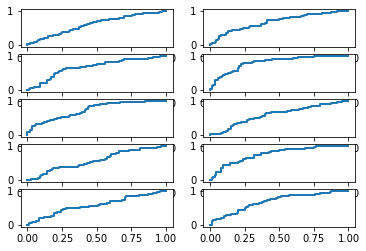

In [4]:
# path
path_train = "data/train/"
# get top 10 breeds
top_10 = labels_or['breed'].value_counts()[:10].index

cor = dict([(breed, idx) for idx, breed in enumerate(top_10)])

preds = []
models = []
y_tests = []
scores = []



for idx, val in enumerate(top_10):
    # aux 
    aux = top_10[~np.isin(np.arange(top_10.size),idx)]
    # divide choosen label and not choosen 
    top_10_lb = labels_or.loc[labels_or['breed'] == top_10[idx]]
    top_10_lb_not = labels_or.loc[labels_or['breed'].isin(aux)]
    
    # number of data points
    numb_breed = top_10_lb['breed'].size

    # choose at random not 1 breed
    rd_breed_ind = top_10_lb_not.sample(n=numb_breed)
    # concatenate labels
    labels = pd.concat([rd_breed_ind,top_10_lb])
    labels = labels.sample(frac = 1)
    
    filenames = [path_train + fname + ".jpg" for fname in labels['id']]

    y = np.array([cor[breed] for breed in labels['breed']])
    
    lb_pred = cor[top_10[idx]]
    
    # Resize images


    IMG_SIZE = 150

    imgs = []
    for fname in filenames:
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC))

    imgs = np.array(imgs)
    
    X = imgs.reshape(imgs.shape[0],imgs.shape[1]*imgs.shape[2]*imgs.shape[3])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

    y_train = (y_train==lb_pred)
    y_test  = (y_test==lb_pred)
    
    y_train = np.array([1 if i == True else 0 for i in y_train])
    y_test = np.array([1 if i == True else 0 for i in y_test])
    
    y_tests.append(y_test)
    
    sgd_clf = SGDClassifier(random_state=42)
    
    #model = sgd_clf.fit(X_train, y_train)
    #models.append(model)

    score = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method="decision_function")
    scores.append(score)
    
    roc_score = roc_auc_score(y_train, score)
    print(f"Roc Auc score: {roc_score}")
    

    print("accuracy: ", accuracy(y_train, score))
    cnf_matrix = confusion_matrix(y_train, score)
    print("Recall: ",cnf_matrix[1][1] / (cnf_matrix[1][1] + cnf_matrix[1][0]))
    print("Precision: ",cnf_matrix[1][1] / (cnf_matrix[1][1] + cnf_matrix[0][1]))
    #print()
    
    
    fpr, tpr, t = roc_curve(y_train, score)
    plt.subplot(5, 2, idx+1)
    plt.plot(fpr,tpr,linewidth=2)
    